In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Datasci 415 Project')

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from logistic_probability import MultiLogisticProbability
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df = pd.read_csv('training_set.csv', usecols= ['ticker', 'time', 'post title sentiment_score',
                                               'post body sentiment_score', 'comment sentiment_score',
                                               'Volume', 'Movement', 'Volume MA', 'Previous Movement'])

In [3]:
df.set_index(['ticker', 'time'], inplace=True)
X = df.loc[:, ~df.columns.str.contains('^Movement$')]
y = df.loc[:, 'Movement']

In [4]:
def backward_elimination(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    dependent_var = target.reset_index(drop=True)
    independent_vars = data.reset_index(drop=True)
    features = sm.add_constant(independent_vars)

    while len(features.columns) > 1:
        model = sm.GLM(dependent_var, features, family=sm.families.Binomial()).fit()
        max_p_value = max(model.pvalues)

        if max_p_value > significance_level:
            excluded_feature = model.pvalues.idxmax()
            features = features.drop(columns=[excluded_feature])
            print(f"Dropped {excluded_feature}: p-value {max_p_value}")
        else:
            break

    return features.columns.tolist(), model

# Perform backward elimination
final_features, final_model = backward_elimination(X, y)
print("Final set of features:", final_features)

Dropped Volume: p-value 0.9521996870755162
Dropped comment sentiment_score: p-value 0.8477085391817663
Dropped post body sentiment_score: p-value 0.8443826803074569
Dropped Previous Movement: p-value 0.7650248263355168
Dropped post title sentiment_score: p-value 0.6975484085628361
Dropped Volume MA: p-value 0.6335029732997267
Final set of features: ['const']


In [18]:
from sklearn.metrics import log_loss, make_scorer
log_loss_scoring = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [20]:
model = LogisticRegression()
kfold = KFold(n_splits=5, shuffle=True)
scores = cross_val_score(model, X, y, cv=kfold, scoring=log_loss_scoring)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [21]:
scores.mean()

-0.7256253397654435

In [7]:
model_full = LogisticRegression()
model_full.fit(X, y)

LogisticRegression()

In [8]:
instance = MultiLogisticProbability(model_full, model_full.predict(X), .50)

In [11]:
instance.evaluate_confusion_matrix(y, model_full.predict(X), 'Movement', 0)

+----------+----------------+-----------------+-----------------+----------------+
|  Class   | True Negatives | False Positives | False Negatives | True Positives |
+----------+----------------+-----------------+-----------------+----------------+
| Movement |       0        |        87       |        0        |       96       |
+----------+----------------+-----------------+-----------------+----------------+


In [10]:
y = pd.DataFrame(y)

In [ ]:
roc_curve(y, model_full.predict(X))

(array([0., 1.]), array([0., 1.]), array([inf,  1.]))

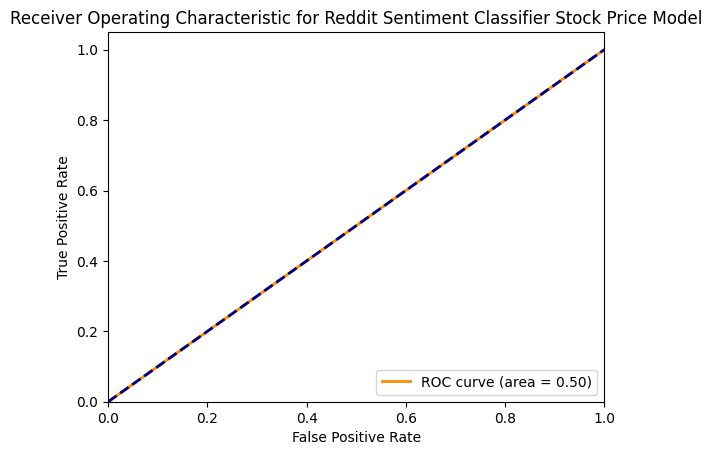

In [12]:
fpr, tpr, _ = roc_curve(y, model_full.predict(X))
roc_auc = auc(fpr, tpr)

# Step 5: Plot the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Reddit Sentiment Classifier Stock Price Model')
plt.legend(loc="lower right")
plt.show()

In [ ]:
features = sm.add_constant(X.reset_index(drop=True))
reduced_features = features.drop(columns=['post title sentiment_score', 'post body sentiment_score', 'comment sentiment_score'])
target = y.reset_index(drop=True)
# Fit the full logistic regression model
model_full = sm.GLM(target, features, family=sm.families.Binomial()).fit()
print(f"Full model summary:\n{model_full.summary()}\n")

# Fit the reduced logistic regression model
model_reduced = sm.GLM(target, reduced_features, family=sm.families.Binomial()).fit()
print(f"Reduced model summary:\n{model_reduced.summary()}\n")

Full model summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:               Movement   No. Observations:                  183
Model:                            GLM   Df Residuals:                      176
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -126.35
Date:                Sat, 07 Dec 2024   Deviance:                       252.70
Time:                        05:47:33   Pearson chi2:                     183.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.002985
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------


In [ ]:
target

,Movement
0,0.0
1,1.0
2,1.0
3,1.0
4,0.0
...,...
178,0.0
179,0.0
180,1.0
181,0.0


In [ ]:
# Calculate the deviance (2 * log-likelihood) for both models
deviance_full = -2 * model_full.llf
deviance_reduced = -2 * model_reduced.llf

# Calculate the chi-square test statistic
chi_square_stat = deviance_reduced - deviance_full

# Degrees of freedom is the difference in the number of parameters
df = len(model_full.params) - len(model_reduced.params)

# Calculate the p-value using the chi-square distribution
from scipy.stats import chi2
p_value = chi2.sf(chi_square_stat, df)

print(f"Chi-square statistic: {chi_square_stat}")
print(f"Degrees of freedom: {df}")
print(f"P-value: {p_value}")

Chi-square statistic: 0.2478214626873978
Degrees of freedom: 3
P-value: 0.9695232696007062


In [9]:
aapl_x = X.loc['AAPL', :]
aapl_y = y.loc['AAPL']
nvda_x = X.loc['NVDA', :]
nvda_y = y.loc['NVDA']
amzn_x = X.loc['AMZN', :]
amzn_y = y.loc['AMZN']
Xs = [aapl_x, nvda_x, amzn_x]
ys = [aapl_y, nvda_y, amzn_y]

In [12]:
for num, x in enumerate(Xs):
  model = LogisticRegression()
  model.fit(x, ys[num])
  predictions = model.predict(x)
  print(classification_report(ys[num], predictions))
  print(f'accuracy: {accuracy_score(ys[num], predictions)}')


              precision    recall  f1-score   support

         0.0       1.00      0.11      0.19        19
         1.0       0.65      1.00      0.78        31

    accuracy                           0.66        50
   macro avg       0.82      0.55      0.49        50
weighted avg       0.78      0.66      0.56        50

accuracy: 0.66
              precision    recall  f1-score   support

         0.0       0.39      0.32      0.35        28
         1.0       0.44      0.52      0.48        29

    accuracy                           0.42        57
   macro avg       0.42      0.42      0.41        57
weighted avg       0.42      0.42      0.42        57

accuracy: 0.42105263157894735
              precision    recall  f1-score   support

         0.0       0.53      0.93      0.67        40
         1.0       0.50      0.08      0.14        36

    accuracy                           0.53        76
   macro avg       0.51      0.50      0.41        76
weighted avg       0.52      